In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [ ]:
# Veri yolu
drive.mount('/content/drive')

# Datasetin bulunduğu yolu belirleyelim
dataset_path = "/content/drive/MyDrive/dataset"

# Train, Validation ve Test dizinlerini oluştur
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "test")

# Parametreler
img_size = (224, 224)  # Görsellerin boyutu
batch_size = 32  # Batch boyutu
num_classes = 3  # Sınıf sayısı

train_ds = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 6739 files belonging to 3 classes.
Found 1685 files belonging to 3 classes.
Found 2106 files belonging to 3 classes.


In [ ]:
# Veri artırma ve ön işleme
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [ ]:
# Vision Transformer için yapı taşları
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("gelu")(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Patch oluşturma ve gömme sınıfı
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [ ]:
# ViT modeli parametreleri
patch_size = 16  # Her patch boyutu
projection_dim = 128  # Projeksiyon boyutu
num_heads = 4  # Transformer başlık sayısı
transformer_units = [projection_dim * 2, projection_dim]  # Transformer MLP birimleri
transformer_layers = 4  # Transformer blok sayısı
mlp_head_units = [256, 128]  # Son MLP katmanı için birimler
dropout_rate = 0.4  # Dropout oranı

# Görüntü boyutlarını hesapla
input_shape = (224, 224, 3)
num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)


In [ ]:
# Vision Transformer modeli oluştur
def create_vit_model():
    inputs = Input(shape=input_shape)

    # Veri artırma uygula
    augmented = data_augmentation(inputs)

    # Rescaling
    x = layers.Rescaling(1.0 / 255)(augmented)

    # Patchlere ayır
    patches = Patches(patch_size)(x)

    # Patchleri kodla
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer blokları ekle
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=dropout_rate)

        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Sınıflandırma için representation oluştur
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)

    # Batch Normalization ekle
    representation = layers.BatchNormalization()(representation)

    # MLP head with Batch Normalization
    features = representation
    for units in mlp_head_units:
        features = layers.Dense(units)(features)
        # Her Dense katmanından sonra Batch Normalization
        features = layers.BatchNormalization()(features)
        features = layers.Activation("gelu")(features)
        features = layers.Dropout(dropout_rate)(features)

    # Sınıflandırma katmanı
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    # Model oluştur
    model = Model(inputs=inputs, outputs=outputs)
    return model

# ViT modelini oluştur
vit_model = create_vit_model()

# Modeli derle
vit_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Model özeti
vit_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches (Patches)         │ (None, None, 768)      │              0 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder             │ (None, 196, 128)       │        123,520 │ patches[0][0]          │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 196, 128)       │            256 │ patch_encoder[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 196, 128)       │        263,808 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 196, 128)       │              0 │ multi_head_attention[… │
│                           │                        │                │ patch_encoder[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 196, 128)       │            256 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 196, 256)       │         33,024 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 196, 256)       │          1,024 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 196, 256)       │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 196, 256)       │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 196, 128)       │         32,896 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 196, 128)       │            512 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 196, 128)       │              0 │ batch_normalization_1… │
├──────────────────────

 Total params: 1,519,235 (5.80 MB)

 Trainable params: 1,515,139 (5.78 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [ ]:
# Early stopping ayarla
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

In [ ]:
# Learning rate azaltma
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6
)


In [ ]:
# Modeli eğit
epochs = 100

history = vit_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 43s 105ms/step - accuracy: 0.4652 - loss: 1.2292 - val_accuracy: 0.3430 - val_loss: 1.1365 - learning_rate: 1.0000e-04
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.5938 - loss: 0.9422 - val_accuracy: 0.5602 - val_loss: 1.0152 - learning_rate: 1.0000e-04
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.6127 - loss: 0.8749 - val_accuracy: 0.6421 - val_loss: 0.8219 - learning_rate: 1.0000e-04
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.6623 - loss: 0.7746 - val_accuracy: 0.6694 - val_loss: 0.8307 - learning_rate: 1.0000e-04
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.6750 - loss: 0.7477 - val_accuracy: 0.5365 - val_loss: 1.1022 - learning_rate: 1.0000e-04
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.6819 - loss: 0.7448 - val_accuracy: 0.6926 - val_loss: 0.7679 - learning_rate: 1.0000e-04
Epoch 7/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 

In [ ]:
# Modeli kaydet
vit_model.save("vit_waste_classification_model.h5")

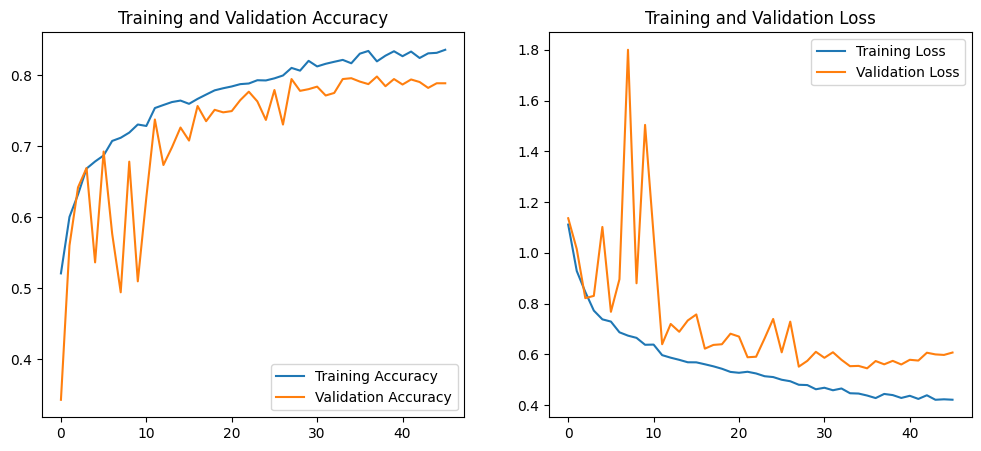

In [ ]:
# Loss ve Accuracy grafikleri
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy grafiği
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    # Loss grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

    plt.show()

# Grafikleri çiz
plot_history(history)

In [ ]:
# Test veri kümesi üzerinde değerlendir
test_loss, test_acc = vit_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8504 - loss: 0.4141
Test Accuracy: 0.8034


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━

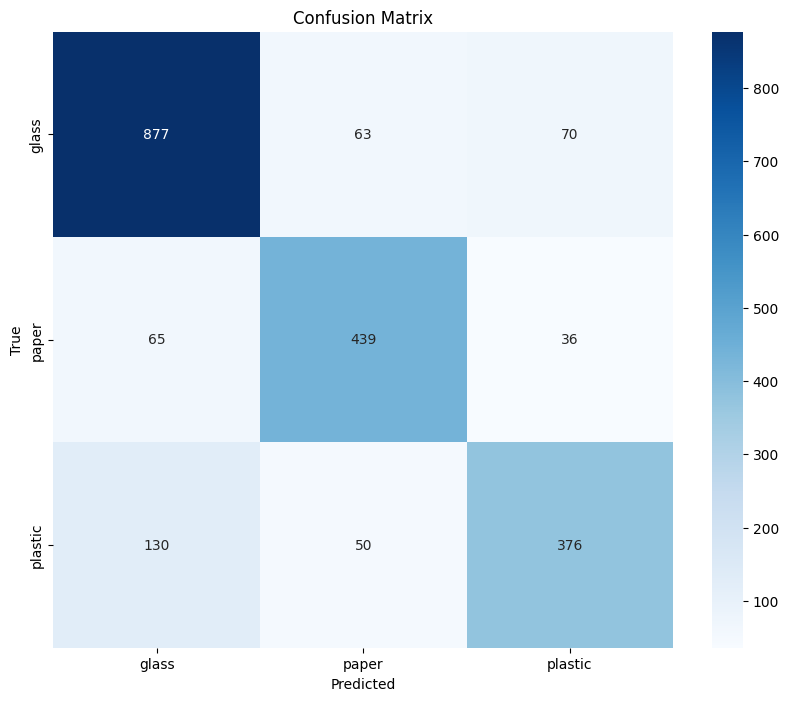

Classification Report:
              precision    recall  f1-score   support

       glass       0.82      0.87      0.84      1010
       paper       0.80      0.81      0.80       540
     plastic       0.78      0.68      0.72       556

    accuracy                           0.80      2106
   macro avg       0.80      0.79      0.79      2106
weighted avg       0.80      0.80      0.80      2106



In [ ]:

# Test veri kümesi üzerinde tahminler
predictions = []
labels = []

for images, label in test_ds:
    pred = vit_model.predict(images)
    pred_classes = np.argmax(pred, axis=1)
    predictions.extend(pred_classes)
    labels.extend(label.numpy())

# Confusion matrix oluştur
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(labels, predictions)
class_names = test_ds.class_names

# Confusion matrix grafiği
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Sınıflandırma raporu
print("Classification Report:")
print(classification_report(labels, predictions, target_names=class_names))